# CarND Project 4, Advance Lane Line
---

## Pipeline, Single Images

### Load camera calibration matrix and distortion

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
%matplotlib inline

import pickle

# Load camera calibration matrix and distortion
camera_cal = 'camera_cal/wide_dist_pickle.p'

with open(camera_cal, mode='rb') as f:
    calibration = pickle.load(f) 

mtx = calibration['mtx']
dist = calibration['dist']

### 1. Distortion Correction

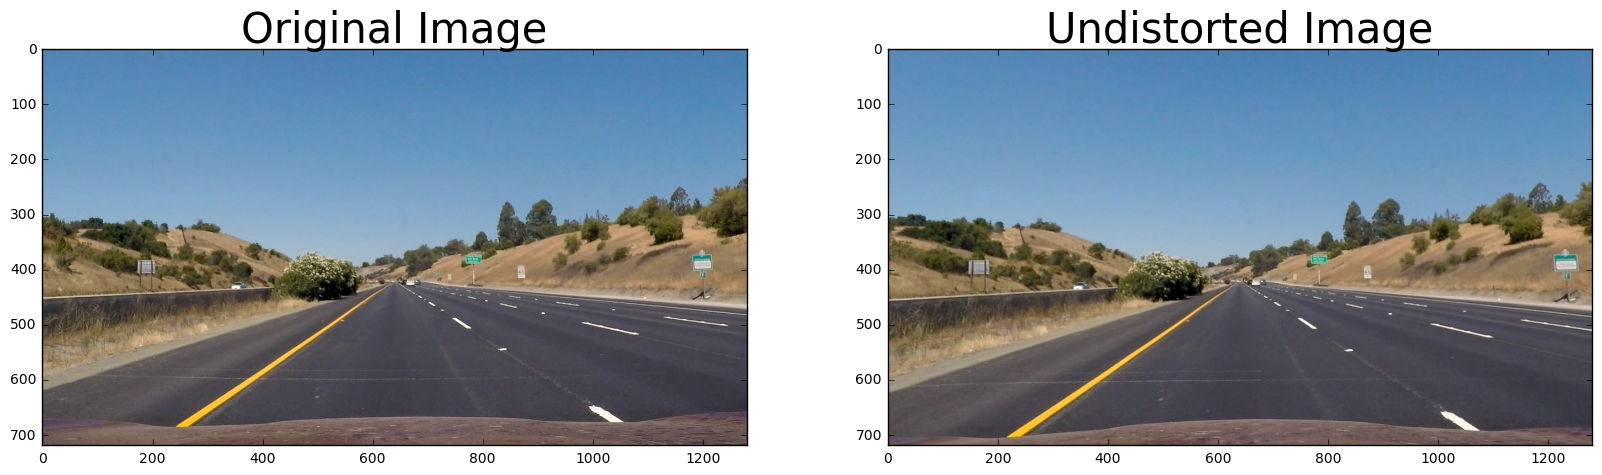

In [2]:
# Test undistortion on an image
#img = cv2.imread('test_images/Screenshot from project_video2.mp4.jpg')
img = cv2.imread('./test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

dst = cv2.undistort(img, mtx, dist, None, mtx)
save_image = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
cv2.imwrite('test_images/test1_undist.jpg',save_image)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### 2. Image Processing

#### 2.1 Sobel Filtering
Sobel filtering is done on the S-Channel of an HLS image.

In [3]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
gray =  hls[:,:,2]


# Function definition for different Sobel Filters

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    if orient == 'x':
        x,y = 1,0
    elif orient == 'y':
        x,y = 0,1
        
    sobel = cv2.Sobel(img, cv2.CV_64F, x, y, ksize=sobel_kernel)
    
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)

    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sbinary

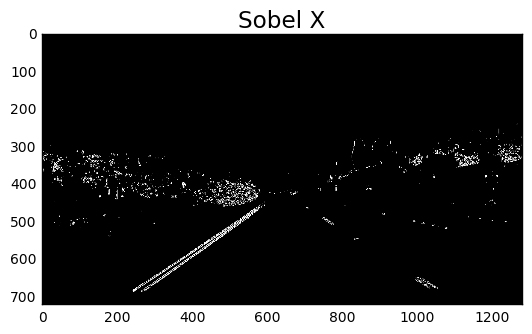

In [21]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(30, 100))

# Plot the result
f, ax1 = plt.subplots(1, 1, figsize=(24/3, 9/3))
f.tight_layout()
ax1.imshow(gradx, cmap='gray')
ax1.set_title('Sobel X', fontsize=50/3)

plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)
plt.show() 

####  2.2 Color Filtering and Thresholding
An HLS image is thresholded on its S-Channel

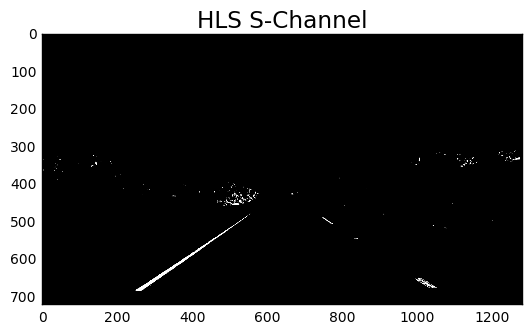

In [20]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

S = hls[:,:,2]

thresh = (225, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1

# Plot the result
f, ax1 = plt.subplots(1, 1, figsize=(24/3, 9/3))
f.tight_layout()
ax1.imshow(binary, cmap='gray')
ax1.set_title('HLS S-Channel', fontsize=50/3)

plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)
plt.show()


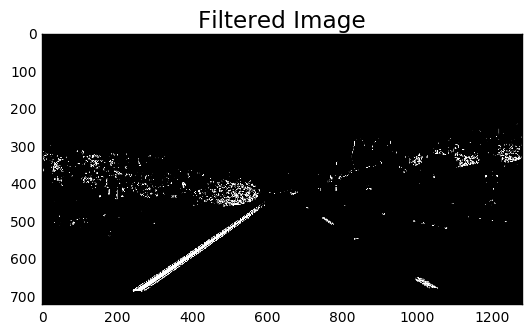

In [22]:
thresholded = np.zeros_like(gradx)
thresholded[(gradx == 1) | (binary == 1)] = 1

# Plot the result
f, ax1 = plt.subplots(1, 1, figsize=(24/3, 9/3))
f.tight_layout()
ax1.imshow(thresholded, cmap='gray')
ax1.set_title('Filtered Image', fontsize=50/3)

plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)
plt.show()

### 3. Perspective Transform

array([[[174, 191, 209],
        [133, 154, 175],
        [118, 144, 171],
        ..., 
        [ 32,  72,  98],
        [  6,  41,  61],
        [ 12,  45,  62]],

       [[131, 152, 173],
        [117, 141, 165],
        [100, 127, 157],
        ..., 
        [ 75, 119, 148],
        [ 47,  85, 108],
        [  2,  37,  57]],

       [[116, 143, 170],
        [101, 130, 160],
        [ 91, 124, 159],
        ..., 
        [ 82, 128, 162],
        [ 76, 120, 149],
        [ 33,  75, 100]],

       ..., 
       [[128, 117, 115],
        [100,  89,  87],
        [ 95,  81,  80],
        ..., 
        [ 85,  70,  67],
        [101,  85,  85],
        [133, 117, 117]],

       [[147, 135, 135],
        [121, 110, 108],
        [102,  91,  89],
        ..., 
        [ 91,  76,  73],
        [125, 109, 109],
        [149, 135, 134]],

       [[189, 177, 177],
        [144, 132, 132],
        [129, 118, 116],
        ..., 
        [127, 112, 109],
        [146, 132, 131],
        [191, 177,

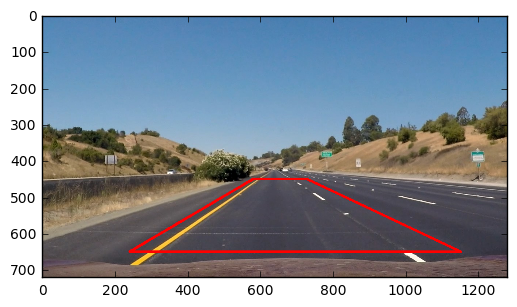

In [7]:
image = img.copy()
plt.imshow(image)

pts = np.array([[727,450],[1150,650],[240,650],[580,450]], np.int32)

pts = pts.reshape((-1,1,2))
cv2.polylines(image,[pts],True,(255,0,0), thickness=5)

In [8]:
def perspective_transform(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    
    # Perspective transform 
    M = cv2.getPerspectiveTransform(src, dst)
       
    # Inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    perspective = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)  
    return M, Minv, perspective

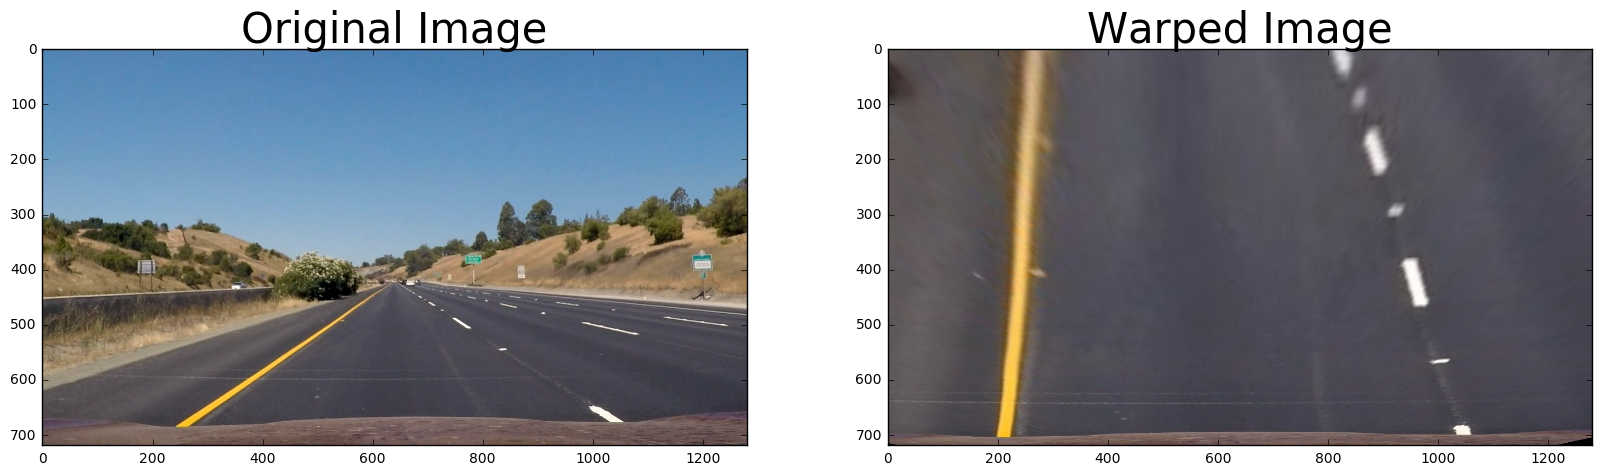

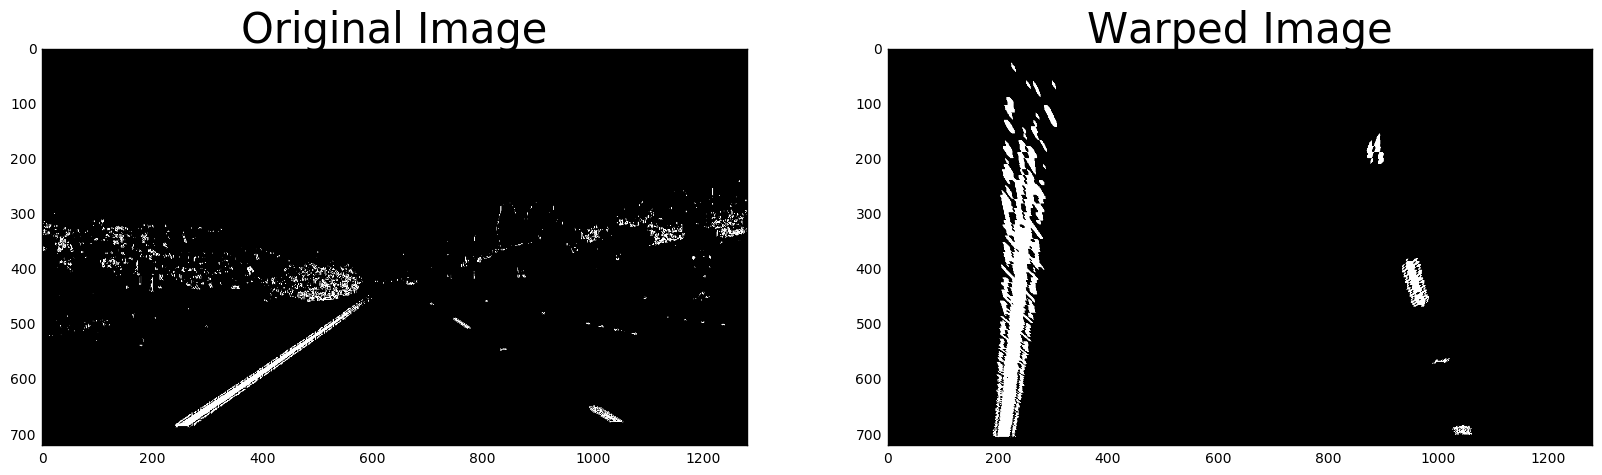

In [9]:
#img_2 = cv2.imread('test_images/test3.jpg')
src = np.float32([[727, 450], [1150, 720], [273, 720], [597, 450]])
dst = np.float32([[1090, 0], [1090, 720], [273, 720], [273, 0]])


M, Minv, perspective = perspective_transform(img, src, dst)

# Visualize warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(perspective)
ax2.set_title('Warped Image', fontsize=30)

M, Minv, perspective = perspective_transform(thresholded, src, dst)

# Visualize warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(thresholded, cmap='gray')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(perspective, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)

### 4. Polynomial Fit

In [10]:
binary_warped = perspective
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print(leftx_base, rightx_base)

230 956


/home/manuel/anaconda2/envs/UdaciousEnvironment/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [11]:
# Choose the number of sliding windows
nwindows = 7
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

In [12]:
# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

In [13]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

print(left_fit, right_fit)

[ -9.54019140e-05   1.23345037e-02   2.49654063e+02] [  3.76339229e-05   2.76098054e-01   8.32713557e+02]


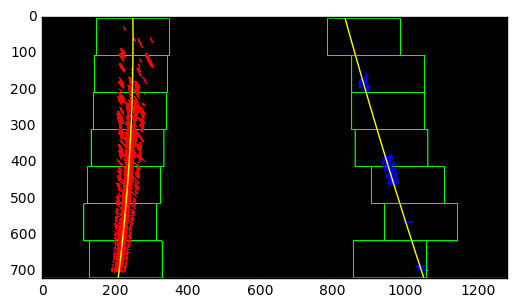

In [14]:
# Generate x and y values for plotting
#linspace(initial, end, number_of_samples)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### 4. Radius of Curvature

In [15]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

5364.00907329 15517.1771709


In [16]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
#left_fit = np.polyfit(lefty, leftx, 2)
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

x_left = left_fit_cr[0] + left_fit_cr[1]*720*ym_per_pix + left_fit_cr[2]*(720**2)*ym_per_pix
x_right = right_fit_cr[0] + right_fit_cr[1]*720*ym_per_pix + right_fit_cr[2]*(720**2)*ym_per_pix

print(x_left)
print(x_right)


# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
curvature = (left_curverad + right_curverad)/2

print(curvature, 'meters')

28503.4076912
95073.1472015
3048.67691364 meters


### 5. Final Result

209.203502481
1050.68332808


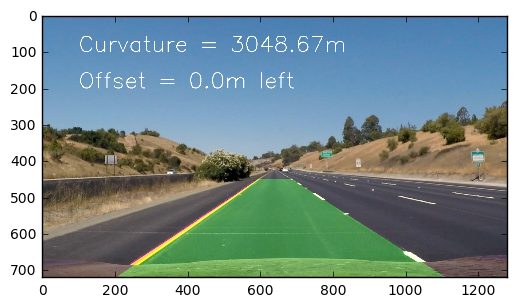

In [17]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw lane lines
color_warp[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 255]
color_warp[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 255, 0]


#Calculate offset position from the center
print(pts_left[0,719][0])
print(pts_right[0,0][0])


car_position = ((pts_left[0,719][0]+pts_right[0,0][0])/2)
offset = (640 - car_position)*xm_per_pix

if offset > 0:
    position = 'left'
elif offset < 0:
    position = 'right'
else:
    position = 'center'
    
offset = np.abs(offset)


#plt.imshow(color_warp)

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

cv2.putText(result, ('Curvature = ' + curvature.astype('str')[0:7]+'m'), (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, [255,255,255], thickness=2)
cv2.putText(result, ('Offset = ' + offset.astype('str')[0:3]+'m ' + position), (100,200), cv2.FONT_HERSHEY_SIMPLEX, 2, [255,255,255], thickness=2)


plt.imshow(result)